# Zillow Analysis

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

## Business Problem

A real estate investment firm is interested in knowing the top three best New Jersey counties to invest in based on return on investment (ROI).  

## Load Data for Analysis

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

## Data Preprocessing

In [5]:
#Convert date columns to datetime objects
def get_datetimes(df):
    non_dt_cols = []
    dt_cols = []
    
    for c in df.columns:
        if c[0].isnumeric():
            dt_cols.append(c)
        else:
            non_dt_cols.append(c)
    #print(non_dt_cols)
    #print(dt_cols)
    dt_cols = list(pd.to_datetime(dt_cols, format = '%Y-%m'))
    
    df.columns = non_dt_cols + dt_cols
    return df

In [6]:
df = get_datetimes(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Reshape from Wide to Long Format

In [8]:
#Function to melt dataframe with datetime columns
def melt_data(df):
    melted = pd.melt(
        df,
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
        var_name='time')
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
#Updated dataframe
melted_df = melt_data(df)
melted_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [10]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  int64         
 2   City        object        
 3   State       object        
 4   Metro       object        
 5   CountyName  object        
 6   SizeRank    int64         
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


## Seperate New Jersey Data

In [11]:
#Select NJ data for analysis
nj_df = melted_df[melted_df['State'] == 'NJ']
nj_df.set_index('time', inplace=True)

In [12]:
nj_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0


In [13]:
nj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133030 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    133030 non-null  int64  
 1   RegionName  133030 non-null  int64  
 2   City        133030 non-null  object 
 3   State       133030 non-null  object 
 4   Metro       133030 non-null  object 
 5   CountyName  133030 non-null  object 
 6   SizeRank    133030 non-null  int64  
 7   value       133030 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 9.1+ MB


In [14]:
#Change columns from int64 to string
nj_df['RegionID'] = nj_df['RegionID'].astype(str)
nj_df['RegionName'] = nj_df['RegionName'].astype(str)
nj_df['SizeRank'] = nj_df['SizeRank'].astype(str)

In [15]:
def plot_values(df, title):
#Plot the average annual home values of a dataframe
    df.resample(rule='A').mean().plot(figsize=(15,5))
    plt.title(title);

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


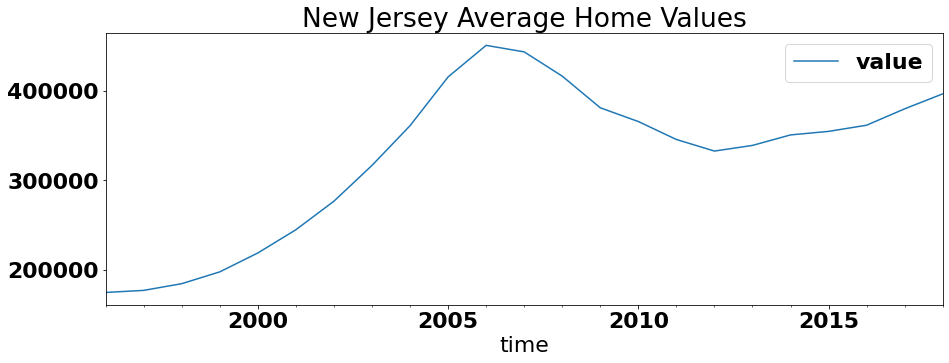

In [16]:
#Plot NJ average home values
plot_values(nj_df, 'New Jersey Average Home Values')

In [17]:
def adfuller_of(series):
    """Prints the Augmented Dickey-Fuller test results."""
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [18]:
#Perfrom Dickey-Fuller test to check for stationarity
#adfuller_of(nj_df['value'])

In [19]:
#ROLL = 12

In [20]:
# Creating rolling mean and std.
#nj_df['rolling_mean'] = nj_df['value'].rolling(window=ROLL).mean()
#nj_df['rolling_std'] = nj_df['value'].rolling(window=ROLL).std()

#fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(nj_df['value'], color='tab:blue', label='Value')
#ax.plot(nj_df['rolling_mean'], color='tab:orange', label='Rolling Mean')
#ax.plot(nj_df['rolling_std'], color='tab:green', label='Rolling Std')
#ax.legend()
#fig.tight_layout()

In [21]:
#df_2 = pd.DataFrame(nj_df['value'])
#df_2.head()

In [22]:
#decomposition = seasonal_decompose(df_2)

In [23]:
#Resample NJ data into yearly average
#nj_df.resample(rule='A').mean()

In [24]:
#roi_lst = []
#roi_lst.append(hudson_roi)

In [25]:
def get_roi(df):
#Calculate return on investment from a datframe
    resampled_df = df.resample(rule='A').mean()
    cost = resampled_df.iloc[0,0]
    value = resampled_df.iloc[-1,0]
    ROI = (value-cost)/cost
    return round(ROI, 2)

In [26]:
get_roi(nj_df)

1.27

In [27]:
#def get_roi(df):
    #cost = df.iloc[0,0]
    #value = df.iloc[-1,0]
    #ROI = (value-cost)/cost
    #return round(ROI, 2)

In [28]:
#Calculate NJ Return on Investment (ROI) from 1996-2018
#get_roi(nj_yearly)

 - Overall New Jersey ROI from 1996 through 2018 was 125%.

## Seperate Data into Individual Counties

In [29]:
#Check unique county names
melted_df[melted_df['State'] == 'NJ']['CountyName'].unique()

array(['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
       'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer',
       'Morris', 'Atlantic', 'Gloucester', 'Cumberland', 'Warren',
       'Hunterdon', 'Cape May', 'Sussex', 'Salem'], dtype=object)

### Hudson County Analysis

In [30]:
def county_df(county):
#Create seperate county dataframes from NJ dataframe
    county_df = nj_df[(nj_df['CountyName'] == county)]
    return county_df

In [31]:
hudson_df = county_df('Hudson')
hudson_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0
1996-04-01,60599,7093,West New York,NJ,New York,Hudson,215,131700.0
1996-04-01,60594,7087,Union City,NJ,New York,Hudson,320,127300.0


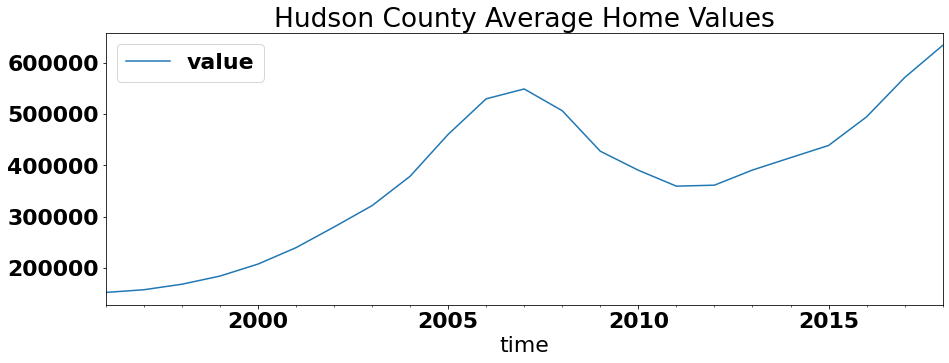

In [32]:
plot_values(hudson_df, 'Hudson County Average Home Values')

In [33]:
#hudson_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
#plt.title('Hudson County Average Home Values');

In [34]:
#Resample Hudson County data into yearly average
#hudson_yearly = hudson_df.resample(rule='A').mean()
#hudson_yearly.head()

In [35]:
#Calculates ROI of a dataframe and appends values to a list
roi_lst = []
def get_roi_lst(df):
    resampled_df = df.resample(rule='A').mean()
    cost = resampled_df.iloc[0,0]
    value = resampled_df.iloc[-1,0]
    ROI = (value-cost)/cost
    roi_lst.append(round(ROI,2))
    return round(ROI,2)

In [36]:
get_roi_lst(hudson_df)

3.15

 - Hudson County ROI from 1996 through 2018 was 315%.

### Ocean County Analysis

In [37]:
ocean_df = county_df('Ocean')
ocean_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0
1996-04-01,61175,8759,Manchester,NJ,New York,Ocean,529,100900.0
1996-04-01,61093,8527,Jackson,NJ,New York,Ocean,569,151000.0
1996-04-01,61173,8757,Berkeley,NJ,New York,Ocean,1069,93200.0


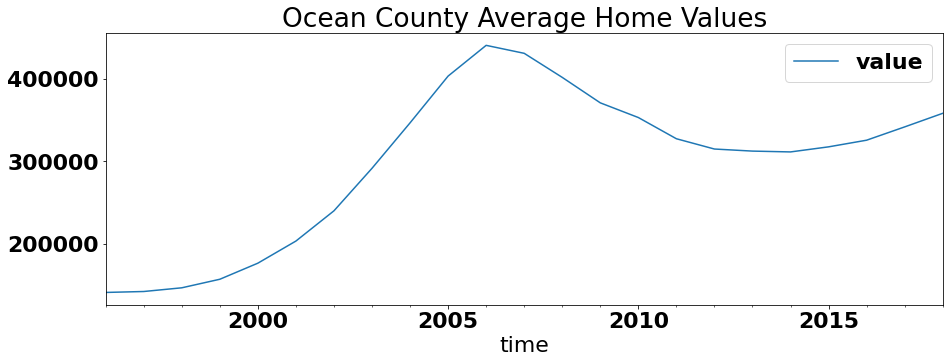

In [38]:
plot_values(ocean_df, 'Ocean County Average Home Values')

In [39]:
get_roi_lst(ocean_df)

1.54

### Middlesex County Analysis

In [40]:
middlesex_df = county_df('Middlesex')
middlesex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61200,8831,Monroe,NJ,New York,Middlesex,279,218500.0
1996-04-01,61214,8854,Piscataway,NJ,New York,Middlesex,1044,161800.0
1996-04-01,61186,8816,East Brunswick,NJ,New York,Middlesex,1180,196000.0
1996-04-01,61187,8817,Edison,NJ,New York,Middlesex,1412,139200.0
1996-04-01,61219,8861,Perth Amboy,NJ,New York,Middlesex,1675,108000.0


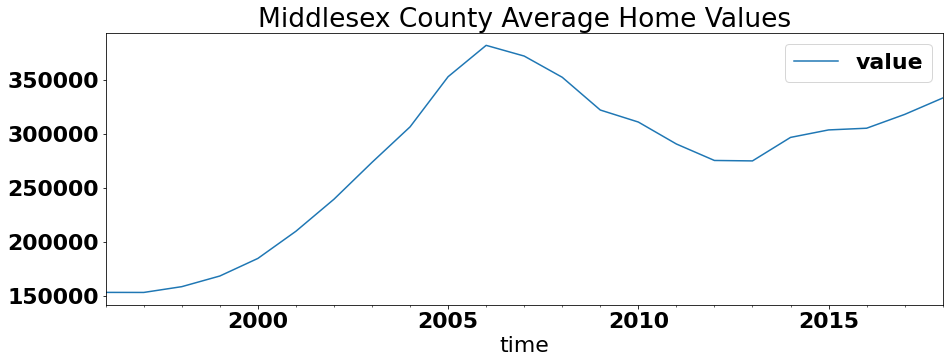

In [41]:
plot_values(middlesex_df, 'Middlesex County Average Home Values')

In [42]:
get_roi_lst(middlesex_df)

1.17

### Somerset County Analysis

In [43]:
somerset_df = county_df('Somerset')
somerset_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61229,8873,Franklin,NJ,New York,Somerset,550,161100.0
1996-04-01,61208,8844,Hillsborough,NJ,New York,Somerset,1942,227200.0
1996-04-01,61181,8807,Bridgewater,NJ,New York,Somerset,2230,222600.0
1996-04-01,60864,7920,Bernards,NJ,New York,Somerset,4073,354600.0
1996-04-01,61231,8876,Branchburg,NJ,New York,Somerset,4987,177200.0


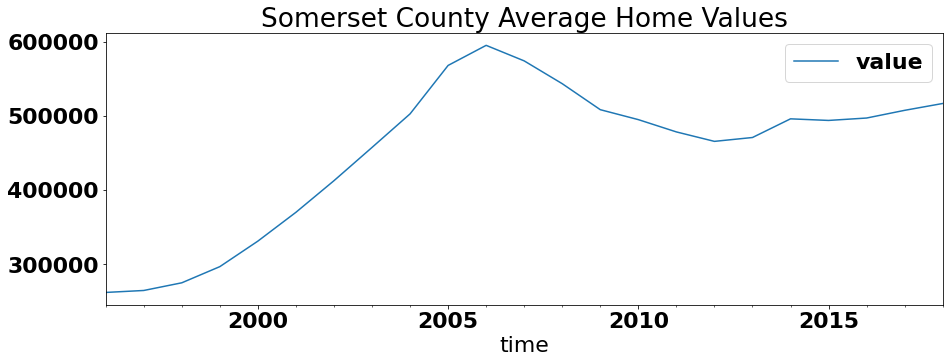

In [44]:
plot_values(somerset_df, 'Somerset County Average Home Values')

In [45]:
get_roi_lst(somerset_df)

0.97

### Monmouth County Analysis

In [46]:
monmouth_df = county_df('Monmouth')
monmouth_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60776,7728,Freehold,NJ,New York,Monmouth,577,200200.0
1996-04-01,60763,7712,Ocean,NJ,New York,Monmouth,1110,159300.0
1996-04-01,60774,7726,Manalapan,NJ,New York,Monmouth,1499,205700.0
1996-04-01,60793,7753,Neptune,NJ,New York,Monmouth,1704,119400.0
1996-04-01,60786,7740,Long Branch,NJ,New York,Monmouth,2483,116100.0


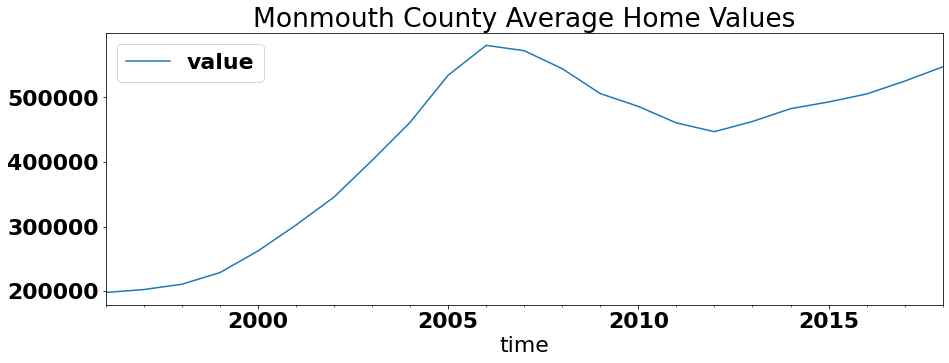

In [47]:
plot_values(monmouth_df, 'Monmouth County Average Home Values')

In [48]:
get_roi_lst(monmouth_df)

1.76

### Passaic County Analysis

In [49]:
passaic_df = county_df('Passaic')
passaic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60565,7055,Passaic,NJ,New York,Passaic,623,133100.0
1996-04-01,60688,7470,Wayne,NJ,New York,Passaic,841,240400.0
1996-04-01,60527,7011,Clifton,NJ,New York,Passaic,3129,147600.0
1996-04-01,60529,7013,Clifton,NJ,New York,Passaic,3969,170800.0
1996-04-01,60694,7501,Paterson,NJ,New York,Passaic,4045,105400.0


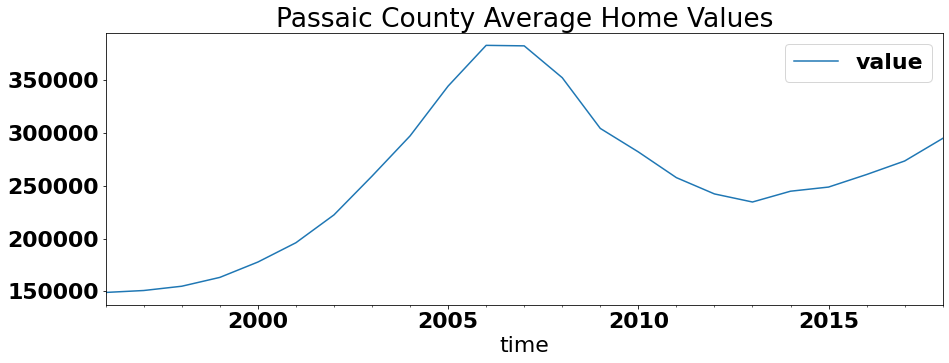

In [50]:
plot_values(passaic_df, 'Passaic County Average Home Values')

In [51]:
get_roi_lst(passaic_df)

0.98

In [52]:
#Check unique cities for Passaic County
#passaic_df.City.unique()

In [53]:
#passaic_df.loc[passaic_df['City'] == 'North Haledon']['value'].plot()

In [54]:
#passaic_df.loc[passaic_df['City'] == 'Clifton']['value'].plot() 

### Essex County Analysis

In [55]:
essex_df = county_df('Essex')
essex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60519,7003,Bloomfield,NJ,New York,Essex,642,140800.0
1996-04-01,60608,7104,Newark,NJ,New York,Essex,1115,114100.0
1996-04-01,60563,7052,West Orange,NJ,New York,Essex,1171,165300.0
1996-04-01,60609,7105,Newark,NJ,New York,Essex,1797,164500.0
1996-04-01,60613,7109,Belleville,NJ,New York,Essex,2698,123400.0


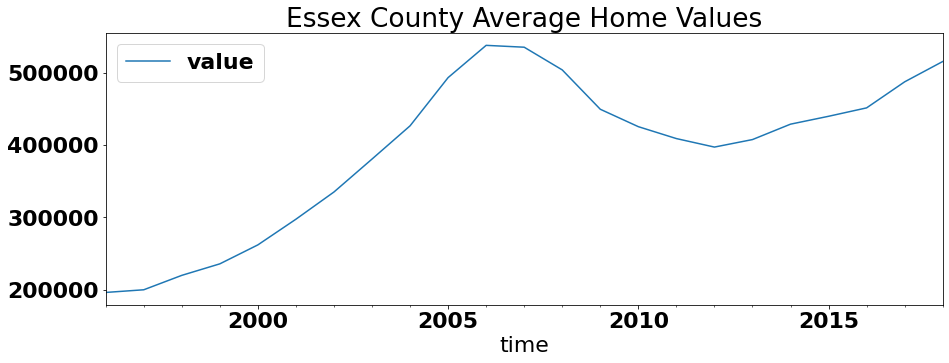

In [56]:
plot_values(essex_df, 'Essex County Average Home Values')

In [57]:
get_roi_lst(essex_df)

1.63

### Camden County Analysis

In [58]:
camden_df = county_df('Camden')
camden_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60916,8021,Lindenwold,NJ,Philadelphia,Camden,679,84800.0
1996-04-01,60971,8081,Winslow,NJ,Philadelphia,Camden,1099,112800.0
1996-04-01,60909,8012,Gloucester,NJ,Philadelphia,Camden,1775,115100.0
1996-04-01,60936,8043,Voorhees,NJ,Philadelphia,Camden,3046,180300.0
1996-04-01,60900,8003,Cherry Hill,NJ,Philadelphia,Camden,3552,170500.0


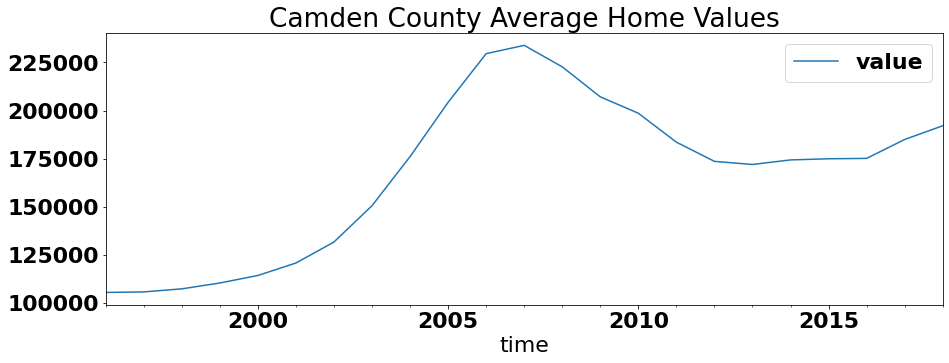

In [59]:
plot_values(camden_df, 'Camden County Average Home Values')

In [60]:
get_roi_lst(camden_df)

0.82

### Bergen County Analysis

In [61]:
bergen_df = county_df('Bergen')
bergen_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60714,7601,Hackensack,NJ,New York,Bergen,833,157500.0
1996-04-01,60540,7024,Fort Lee,NJ,New York,Bergen,948,260200.0
1996-04-01,60750,7666,Teaneck,NJ,New York,Bergen,2344,170800.0
1996-04-01,60656,7410,Fair Lawn,NJ,New York,Bergen,3204,180500.0
1996-04-01,60729,7631,Englewood,NJ,New York,Bergen,3954,163300.0


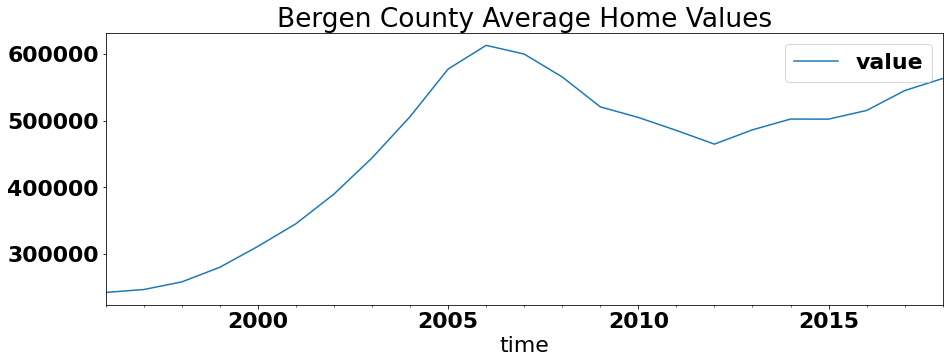

In [62]:
plot_values(bergen_df, 'Bergen County Average Home Values')

In [63]:
get_roi_lst(bergen_df)

1.32

In [64]:
#bergen_cities = bergen_df.groupby(['time', 'City']).aggregate({'value':'mean'})
#bergen_cities.head()

In [65]:
#bergen_df.groupby(['time', 'City'])['value'].mean()

In [66]:
#bergen_cities.resample(rule='A').mean()

### Burlington County Analysis

In [67]:
burlington_df = county_df('Burlington')
burlington_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60945,8054,Mt Laurel,NJ,Philadelphia,Burlington,851,158500.0
1996-04-01,60944,8053,Evesham,NJ,Philadelphia,Burlington,917,149400.0
1996-04-01,60912,8016,Burlington,NJ,Philadelphia,Burlington,2893,121100.0
1996-04-01,60938,8046,Willingboro,NJ,Philadelphia,Burlington,3535,89600.0
1996-04-01,60965,8075,Delran,NJ,Philadelphia,Burlington,3550,117400.0


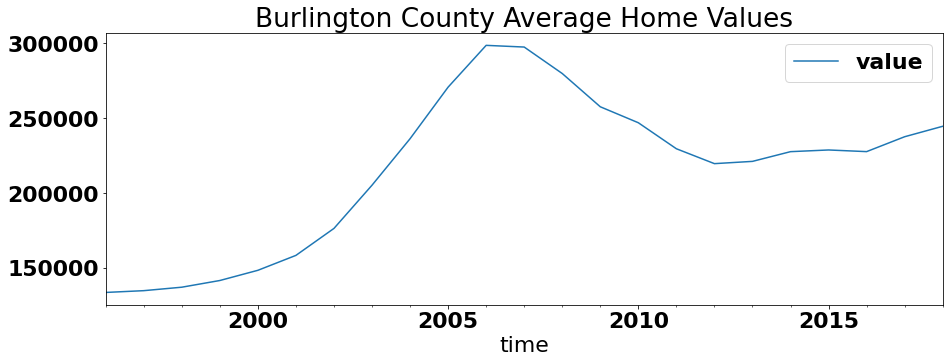

In [68]:
plot_values(burlington_df, 'Burlington County Average Home Values')

In [69]:
get_roi_lst(burlington_df)

0.83

### Union County Analysis

In [70]:
union_df = county_df('Union')
union_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60592,7083,Union,NJ,New York,Union,862,152400.0
1996-04-01,60551,7036,Linden,NJ,New York,Union,1582,131700.0
1996-04-01,60569,7060,Plainfield,NJ,New York,Union,2282,126300.0
1996-04-01,60632,7202,Elizabeth,NJ,New York,Union,2350,123000.0
1996-04-01,60574,7065,Rahway,NJ,New York,Union,3396,126400.0


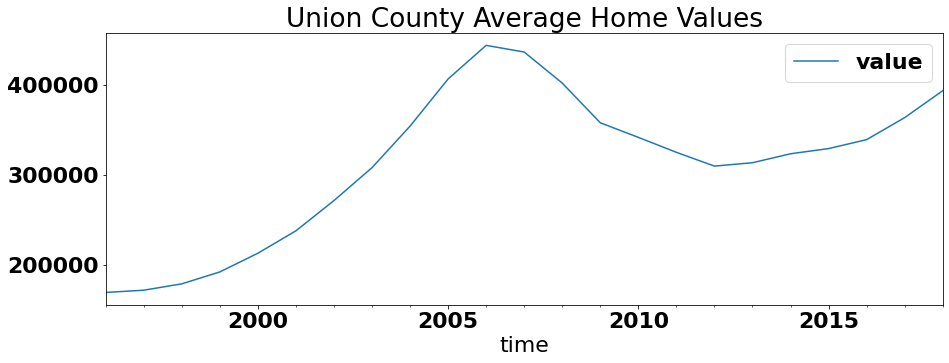

In [71]:
plot_values(union_df, 'Union County Average Home Values')

In [72]:
get_roi_lst(union_df)

1.33

### Mercer County Analysis

In [73]:
mercer_df = county_df('Mercer')
mercer_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61100,8540,Princeton,NJ,Trenton,Mercer,989,270200.0
1996-04-01,61129,8618,Trenton,NJ,Trenton,Mercer,2418,74700.0
1996-04-01,61141,8648,Lawrence,NJ,Trenton,Mercer,3098,161000.0
1996-04-01,61127,8610,Hamilton,NJ,Trenton,Mercer,3310,100500.0
1996-04-01,61090,8520,East Windsor,NJ,Trenton,Mercer,3909,139500.0


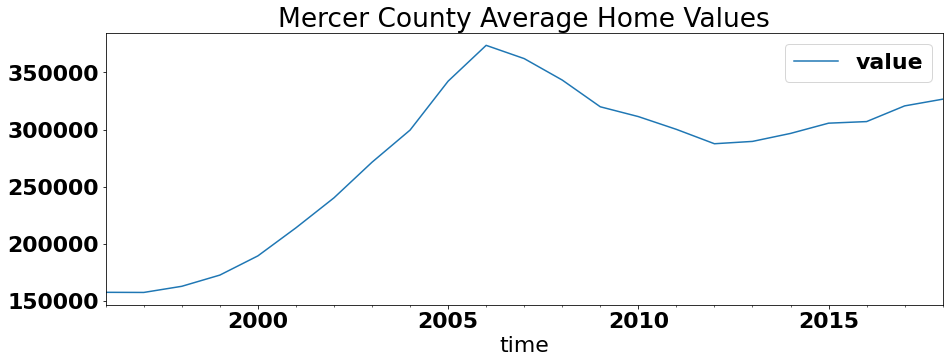

In [74]:
plot_values(mercer_df, 'Mercer County Average Home Values')

In [75]:
get_roi_lst(mercer_df)

1.07

### Morris County Analysis

In [76]:
morris_df = county_df('Morris')
morris_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60884,7960,Morris,NJ,New York,Morris,1281,285900.0
1996-04-01,60564,7054,Parsippany-Troy Hills,NJ,New York,Morris,3444,220700.0
1996-04-01,60848,7869,Randolph,NJ,New York,Morris,4926,253900.0
1996-04-01,60847,7866,Rockaway,NJ,New York,Morris,5332,165800.0
1996-04-01,60806,7801,Dover,NJ,New York,Morris,5527,134200.0


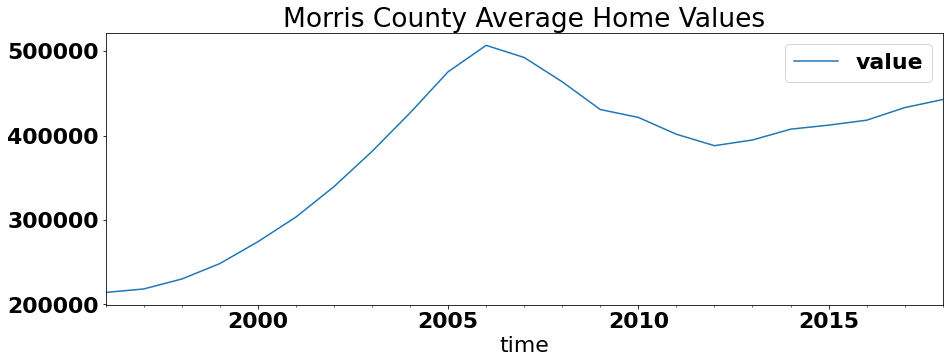

In [77]:
plot_values(morris_df, 'Morris County Average Home Values')

In [78]:
get_roi_lst(morris_df)

1.07

### Atlantic County Analysis

In [79]:
atlantic_df = county_df('Atlantic')
atlantic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61021,8234,Egg Harbor,NJ,Atlantic City,Atlantic,1481,133900.0
1996-04-01,61056,8330,Hamilton,NJ,Atlantic City,Atlantic,3530,103800.0
1996-04-01,61003,8205,Galloway,NJ,Atlantic City,Atlantic,3758,116600.0
1996-04-01,60931,8037,Hammonton,NJ,Atlantic City,Atlantic,4930,97000.0
1996-04-01,61079,8406,Ventnor City,NJ,Atlantic City,Atlantic,6415,119300.0


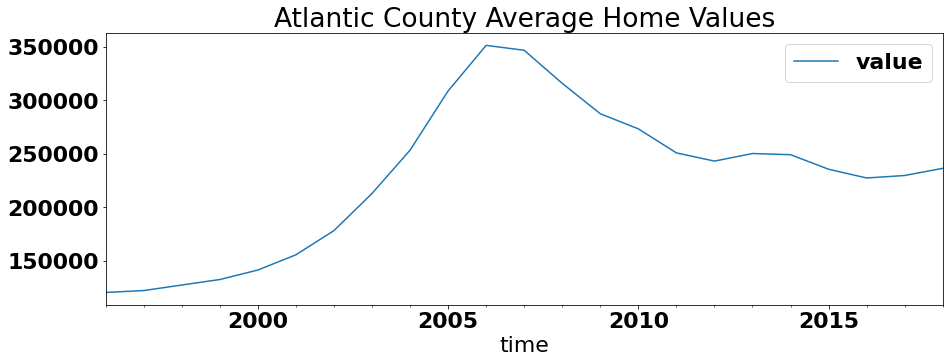

In [80]:
plot_values(atlantic_df, 'Atlantic County Average Home Values')

In [81]:
get_roi_lst(atlantic_df)

0.96

### Gloucester County Analysis

In [82]:
gloucester_df = county_df('Gloucester')
gloucester_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60983,8094,Monroe,NJ,Philadelphia,Gloucester,1745,105600.0
1996-04-01,60985,8096,Deptford,NJ,Philadelphia,Gloucester,2060,99600.0
1996-04-01,60970,8080,Washington,NJ,Philadelphia,Gloucester,2330,140000.0
1996-04-01,60922,8028,Glassboro,NJ,Philadelphia,Gloucester,5606,106100.0
1996-04-01,60974,8085,Woolwich,NJ,Philadelphia,Gloucester,6170,149300.0


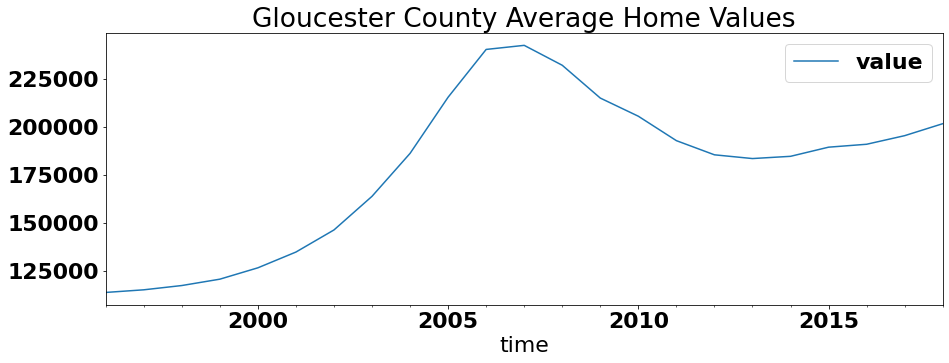

In [83]:
plot_values(gloucester_df, 'Gloucester County Average Home Values')

In [84]:
get_roi_lst(gloucester_df)

0.77

### Cumberland County Analysis

In [85]:
cumberland_df = county_df('Cumberland')
cumberland_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61071,8360,Vineland,NJ,Vineland,Cumberland,1779,80000.0
1996-04-01,61036,8302,Bridgeton,NJ,Vineland,Cumberland,2116,75500.0
1996-04-01,61057,8332,Millville,NJ,Vineland,Cumberland,2221,71900.0
1996-04-01,61072,8361,Vineland,NJ,Vineland,Cumberland,6380,113200.0
1996-05-01,61071,8360,Vineland,NJ,Vineland,Cumberland,1779,80000.0


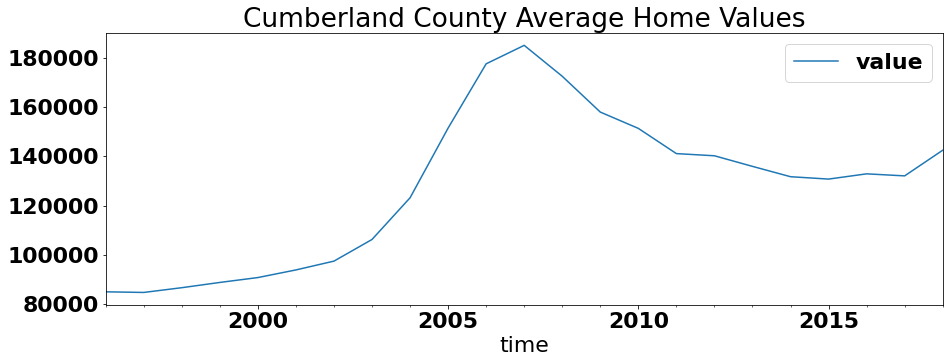

In [86]:
plot_values(cumberland_df, 'Cumberland County Average Home Values')

In [87]:
get_roi_lst(cumberland_df)

0.68

### Warren County Analysis

In [88]:
warren_df = county_df('Warren')
warren_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60828,7840,Hackettstown,NJ,Allentown,Warren,2987,154500.0
1996-04-01,61222,8865,Phillipsburg,NJ,Allentown,Warren,3080,98700.0
1996-04-01,60859,7882,Washington,NJ,Allentown,Warren,6995,133700.0
1996-04-01,60814,7825,Blairstown,NJ,Allentown,Warren,9049,171000.0
1996-04-01,60813,7823,Belvidere,NJ,Allentown,Warren,9157,126800.0


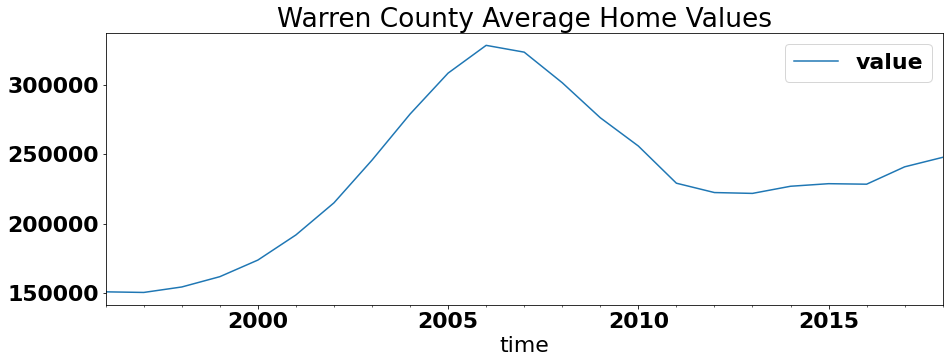

In [89]:
plot_values(warren_df, 'Warren County Average Home Values')

In [90]:
get_roi_lst(warren_df)

0.64

### Hunterdon County Analysis

In [91]:
hunterdon_df = county_df('Hunterdon')
hunterdon_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61191,8822,Raritan,NJ,New York,Hunterdon,3254,223400.0
1996-04-01,61241,8889,Readington,NJ,New York,Hunterdon,8617,236000.0
1996-04-01,61202,8833,Clinton,NJ,New York,Hunterdon,8917,276400.0
1996-04-01,61095,8530,Lambertville,NJ,New York,Hunterdon,9026,173700.0
1996-04-01,61210,8848,Holland,NJ,New York,Hunterdon,9267,177100.0


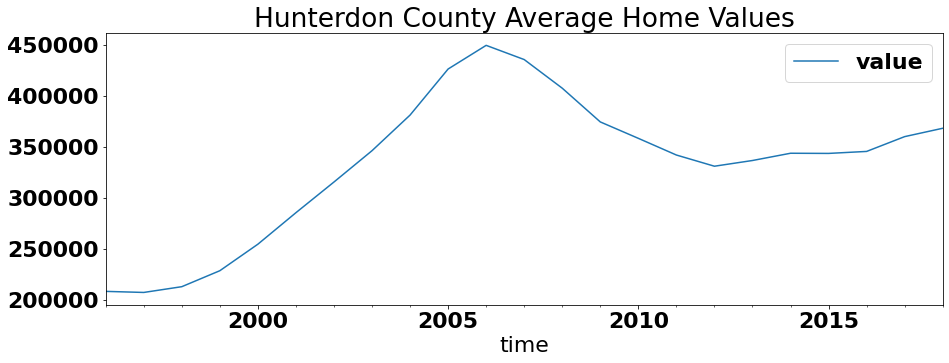

In [92]:
plot_values(hunterdon_df, 'Hunterdon County Average Home Values')

In [93]:
get_roi_lst(hunterdon_df)

0.77

### Cape May County Analysis

In [94]:
cape_may_df = county_df('Cape May')
cape_may_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61017,8226,Ocean City,NJ,Ocean City,Cape May,3631,182400.0
1996-04-01,61002,8204,Lower,NJ,Ocean City,Cape May,4537,107700.0
1996-04-01,61004,8210,Middle,NJ,Ocean City,Cape May,5878,93300.0
1996-04-01,61034,8260,North Wildwood,NJ,Ocean City,Cape May,6038,89500.0
1996-04-01,61032,8251,Villas,NJ,Ocean City,Cape May,7399,61800.0


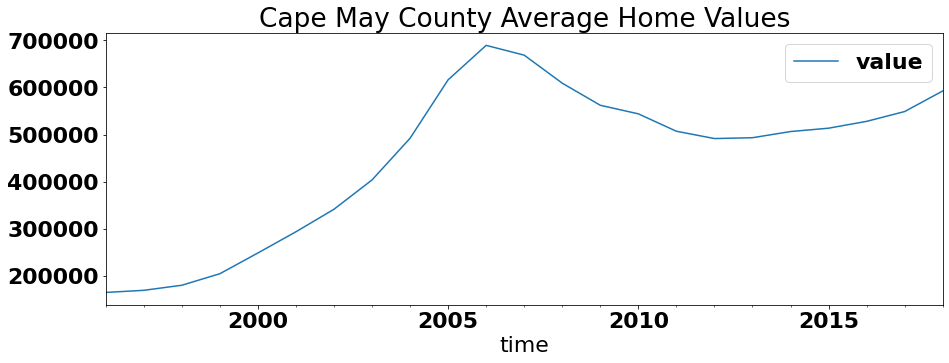

In [95]:
plot_values(cape_may_df, 'Cape May County Average Home Values')

In [96]:
get_roi_lst(cape_may_df)

2.61

### Sussex County Analysis

In [97]:
sussex_df = county_df('Sussex')
sussex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60844,7860,Newton,NJ,New York,Sussex,4412,136300.0
1996-04-01,60850,7871,Sparta,NJ,New York,Sussex,5720,190000.0
1996-04-01,60684,7461,Wantage,NJ,New York,Sussex,6188,137500.0
1996-04-01,60830,7843,Hopatcong,NJ,New York,Sussex,7883,121200.0
1996-04-01,60660,7419,Hardyston,NJ,New York,Sussex,8472,134300.0


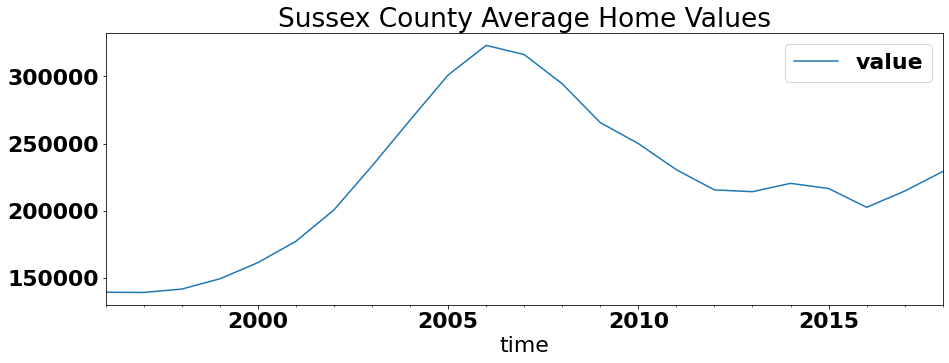

In [98]:
plot_values(sussex_df, 'Sussex County Average Home Values')

In [99]:
get_roi_lst(sussex_df)

0.64

### Salem County Analysis

In [100]:
salem_df = county_df('Salem')
salem_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60960,8070,Pennsville,NJ,Philadelphia,Salem,7321,90700.0
1996-04-01,60959,8069,Carneys Point,NJ,Philadelphia,Salem,7541,70500.0
1996-04-01,61045,8318,Pittsgrove,NJ,Philadelphia,Salem,7902,89000.0
1996-04-01,60969,8079,Salem,NJ,Philadelphia,Salem,8038,68000.0
1996-04-01,60987,8098,Pilesgrove,NJ,Philadelphia,Salem,8960,106000.0


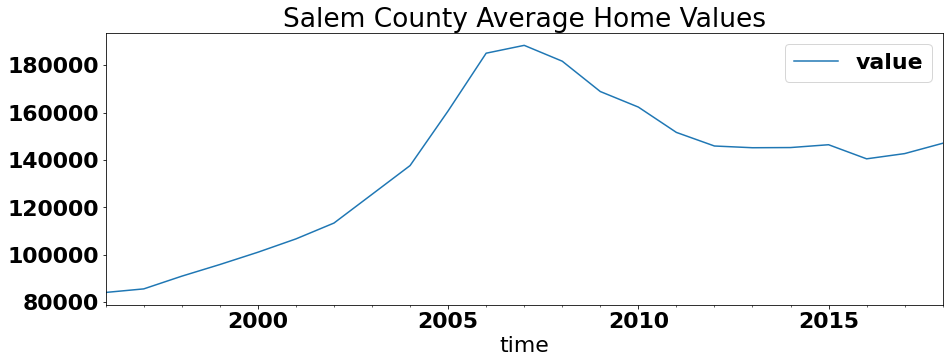

In [101]:
plot_values(salem_df, 'Salem County Average Home Values')

In [102]:
get_roi_lst(salem_df)

0.75

## County ROI Analysis

In [103]:
roi_lst

[3.15,
 1.54,
 1.17,
 0.97,
 1.76,
 0.98,
 1.63,
 0.82,
 1.32,
 0.83,
 1.33,
 1.07,
 1.07,
 0.96,
 0.77,
 0.68,
 0.64,
 0.77,
 2.61,
 0.64,
 0.75]

In [104]:
unique_counties = []
for c in nj_df.CountyName.unique():
    unique_counties.append(c)
print(unique_counties)

['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic', 'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer', 'Morris', 'Atlantic', 'Gloucester', 'Cumberland', 'Warren', 'Hunterdon', 'Cape May', 'Sussex', 'Salem']


In [105]:
roi_dict = dict(zip(unique_counties, roi_lst))

In [106]:
roi_dict

{'Hudson': 3.15,
 'Ocean': 1.54,
 'Middlesex': 1.17,
 'Somerset': 0.97,
 'Monmouth': 1.76,
 'Passaic': 0.98,
 'Essex': 1.63,
 'Camden': 0.82,
 'Bergen': 1.32,
 'Burlington': 0.83,
 'Union': 1.33,
 'Mercer': 1.07,
 'Morris': 1.07,
 'Atlantic': 0.96,
 'Gloucester': 0.77,
 'Cumberland': 0.68,
 'Warren': 0.64,
 'Hunterdon': 0.77,
 'Cape May': 2.61,
 'Sussex': 0.64,
 'Salem': 0.75}

In [107]:
county_roi_df = pd.DataFrame(list(roi_dict.items()),columns = ['County','Average Return on Investment']) 
county_roi_df.sort_values(by='Average Return on Investment', ascending=False, inplace=True)
county_roi_df.reset_index(drop=True)

,County,Average Return on Investment
0,Hudson,3.15
1,Cape May,2.61
2,Monmouth,1.76
3,Essex,1.63
4,Ocean,1.54
5,Union,1.33
6,Bergen,1.32
7,Middlesex,1.17
8,Mercer,1.07
9,Morris,1.07


In [108]:
hudson_yearly = hudson_df['value'].resample(rule='A').mean()
cape_may_yearly = cape_may_df['value'].resample(rule='A').mean()
monmouth_yearly = monmouth_df['value'].resample(rule='A').mean()

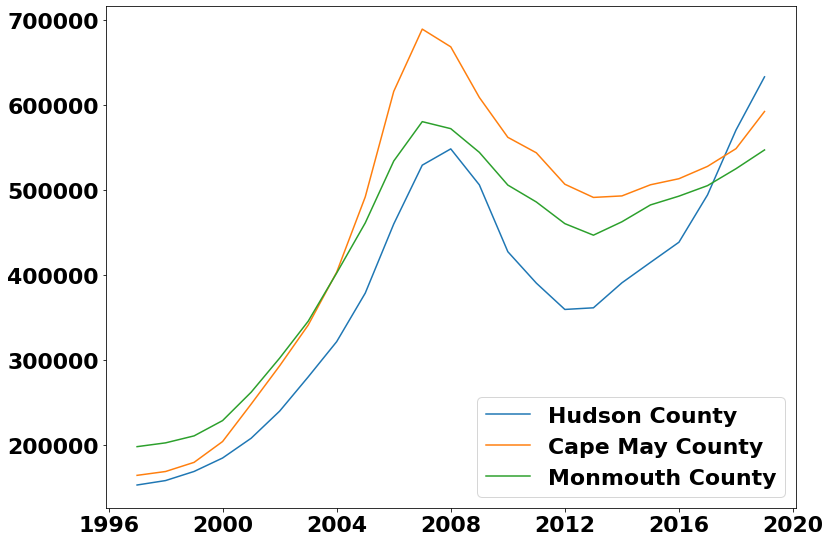

In [109]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hudson_yearly, color='tab:blue', label='Hudson County')
ax.plot(cape_may_yearly, color='tab:orange', label='Cape May County')
ax.plot(monmouth_yearly, color='tab:green', label='Monmouth County')
ax.legend()
fig.tight_layout()

## ARIMA Modeling

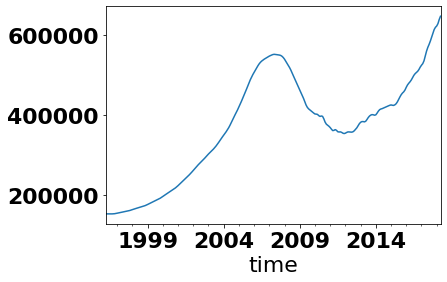

In [110]:
hudson_monthly = hudson_df.resample(rule='M').mean()
hudson_monthly['value'].plot();

In [111]:
#result = seasonal_decompose(hudson_monthly['value'])
#plt.gcf().autofmt_xdate()
#result.plot()

In [112]:
stepwise_fit = auto_arima(hudson_monthly['value'], trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5020.377, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5107.194, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5073.207, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5080.000, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5162.038, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5040.837, Time=1.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4998.435, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4995.994, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5065.934, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5072.926, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5002.610, Time=0.27 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.613 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2493.997
Date:                Sun, 16 May 2021   AIC                           4995.994
Time:                        16:05:51   BIC                           5010.298
Sample:                             0   HQIC                          5001.741
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     68.6273     34.672      1.979      0.048       0.672     136.582
ar.L1          0.9343      0.016     57.300      0.000       0.902       0.966
ma.L1         -0.8756      0.020    -42.871      0.000      -0.916      -0.836
sigma2      8.785e+06      0.000   1.79e+10      0.000    8.78e+06    8.78e+06
===================================================================================
Ljung-Box (L1) (Q):                 211.20   Jarque-Bera (JB):                49.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.73
Prob(H) (two-sided):                  0.45   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.55e+25. Standard errors may be unstable.
"""

In [113]:
len(hudson_monthly)

265

In [114]:
train = hudson_monthly.iloc[:205]
test = hudson_monthly.iloc[205:]

In [115]:
train.isna().sum()

value    0
dtype: int64

In [116]:
model = ARIMA(train['value'], order=(2,2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.value   No. Observations:                  203
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1565.353
Method:                       css-mle   S.D. of innovations            526.706
Date:                Sun, 16 May 2021   AIC                           3142.705
Time:                        16:05:52   BIC                           3162.584
Sample:                    06-30-1996   HQIC                          3150.747
                         - 04-30-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7336     74.322      0.010      0.992    -144.935     146.402
ar.L1.D2.value    -0.3859      0.063     -6.086      0.000      -0.510      -0.262
ar.L2.D2.value    -0.4344      0.063     -6.875      0.000      -0.558      -0.311
ma.L1.D2.value     1.6649        nan        nan        nan         nan         nan
ma.L2.D2.value     1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4442           -1.4508j            1.5173           -0.2973
AR.2           -0.4442           +1.4508j            1.5173            0.2973
MA.1           -0.8325           -0.5541j            1.0000           -0.4065
MA.2           -0.8325           +0.5541j            1.0000            0.4065
-----------------------------------------------------------------------------
"""

In [117]:
#hudson_mean = hudson_df.groupby('time').aggregate({'value':'mean'})
#hudson_mean.head()

In [118]:
# Creating rolling mean and std.
#hudson_mean['rolling_mean'] = hudson_mean['value'].rolling(window=ROLL).mean()
#hudson_mean['rolling_std'] = hudson_mean['value'].rolling(window=ROLL).std()

#fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(hudson_mean['value'], color='tab:blue', label='Value')
#ax.plot(hudson_mean['rolling_mean'], color='tab:orange', label='Rolling Mean')
#ax.plot(hudson_mean['rolling_std'], color='tab:green', label='Rolling Std')
#ax.legend()
#fig.tight_layout()

In [119]:
#decomposition = seasonal_decompose(hudson_mean['value'])
#decomposition.plot()

In [120]:
#hudson_value = hudson_mean[['value']]

In [121]:
#hudson_shift_12 = hudson_value.shift(periods=12)

#lag_12 = pd.concat([hudson_shift_12, hudson_value], axis=1)

#lag_12.corr()

In [122]:
#lag_12.plot(figsize=(18,6));

In [123]:
#plt.figure(figsize=(12,5))
#pd.plotting.autocorrelation_plot(hudson_value);

In [124]:
#Plot the autocorrelation function
#plot_acf(hudson_value);

In [125]:
#plot_pacf(hudson_value);

## SARIMA Modeling

In [126]:
auto_arima(hudson_monthly['value'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -2493.679
Date:                Sun, 16 May 2021   AIC                           4999.358
Time:                        16:06:25   BIC                           5020.814
Sample:                             0   HQIC                          5007.980
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     90.8769     43.061      2.110      0.035       6.480     175.274
ar.L1          0.9270      0.022     41.676      0.000       0.883       0.971
ma.L1         -0.8642      0.025    -35.200      0.000      -0.912      -0.816
ma.L2         -0.0127      0.009     -1.465      0.143      -0.030       0.004
ma.L3          0.0123      0.008      1.473      0.141      -0.004       0.029
sigma2      8.945e+06      0.001   1.01e+10      0.000    8.94e+06    8.94e+06
===================================================================================
Ljung-Box (L1) (Q):                 209.32   Jarque-Bera (JB):                55.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.76
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+26. Standard errors may be unstable.
"""

In [127]:
len(hudson_monthly)

265

In [128]:
train_2 = hudson_monthly.iloc[:229]
test_2 = hudson_monthly.iloc[229:]

In [129]:
model_2 = SARIMAX(hudson_monthly['value'], order = (1,1,3))

In [130]:
results = model_2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -2529.511
Date:                Sun, 16 May 2021   AIC                           5069.022
Time:                        16:06:26   BIC                           5086.902
Sample:                    04-30-1996   HQIC                          5076.207
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.002    473.537      0.000       0.995       1.003
ma.L1         -0.8887      0.006   -151.697      0.000      -0.900      -0.877
ma.L2         -0.0161      0.008     -1.919      0.055      -0.033       0.000
ma.L3         -0.0909      0.010     -8.759      0.000      -0.111      -0.071
sigma2      1.201e+07   1.68e-11   7.14e+17      0.000     1.2e+07     1.2e+07
===================================================================================
Ljung-Box (L1) (Q):                 195.66   Jarque-Bera (JB):               146.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -1.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.09e+33. Standard errors may be unstable.
"""

In [131]:
start = len(train_2)
end = len(train_2) + len(test) - 1

In [132]:
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')
predictions

2015-05-31    425941.158653
2015-06-30    428967.756629
2015-07-31    433947.230533
2015-08-31    440636.496068
2015-09-30    446654.709420
2015-10-31    452115.326130
2015-11-30    456045.581545
2015-12-31    458896.231371
2016-01-31    463599.924665
2016-02-29    470820.432647
2016-03-31    476778.371223
2016-04-30    480694.933425
2016-05-31    484195.101231
2016-06-30    488877.285843
2016-07-31    494817.320002
2016-08-31    500669.120790
2016-09-30    504590.482270
2016-10-31    507235.537430
2016-11-30    510186.497474
2016-12-31    514921.845764
2017-01-31    521114.639389
2017-02-28    525771.853130
2017-03-31    529530.743335
2017-04-30    537032.161744
2017-05-31    549429.242574
2017-06-30    562404.506739
2017-07-31    571383.369190
2017-08-31    578275.376743
2017-09-30    586680.953984
2017-10-31    596836.818342
2017-11-30    607218.833766
2017-12-31    615656.045217
2018-01-31    620792.440932
2018-02-28    623682.816299
2018-03-31    629842.415447
2018-04-30    641001

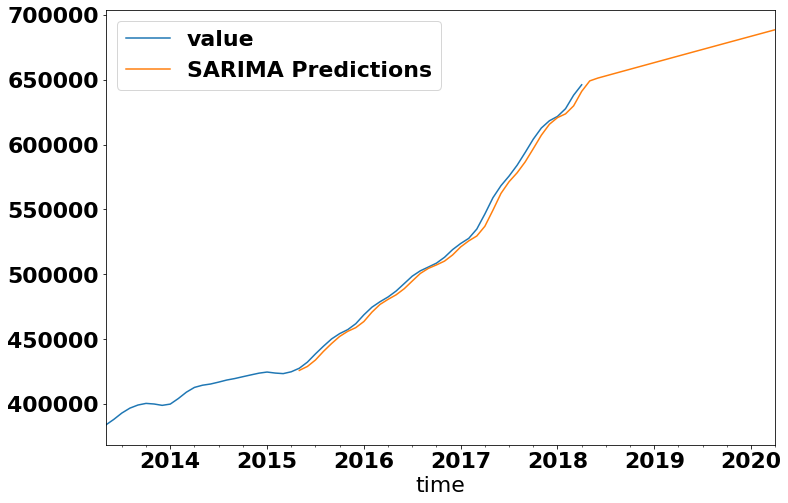

In [133]:
test['value'].plot(legend=True,figsize=(12,8))
predictions.plot(legend=True);

In [134]:
future_model = SARIMAX(hudson_monthly['value'], order = (1,1,3))
results_future = future_model.fit()

In [135]:
fcast = results_future.predict(len(hudson_monthly), len(hudson_monthly)+11, typ='levels').rename('SARIMA Forecast')
fcast

2018-05-31    649085.524619
2018-06-30    651255.799674
2018-07-31    652963.120016
2018-08-31    654669.323853
2018-09-30    656374.411915
2018-10-31    658078.384932
2018-11-30    659781.243633
2018-12-31    661482.988747
2019-01-31    663183.621001
2019-02-28    664883.141124
2019-03-31    666581.549843
2019-04-30    668278.847885
Freq: M, Name: SARIMA Forecast, dtype: float64

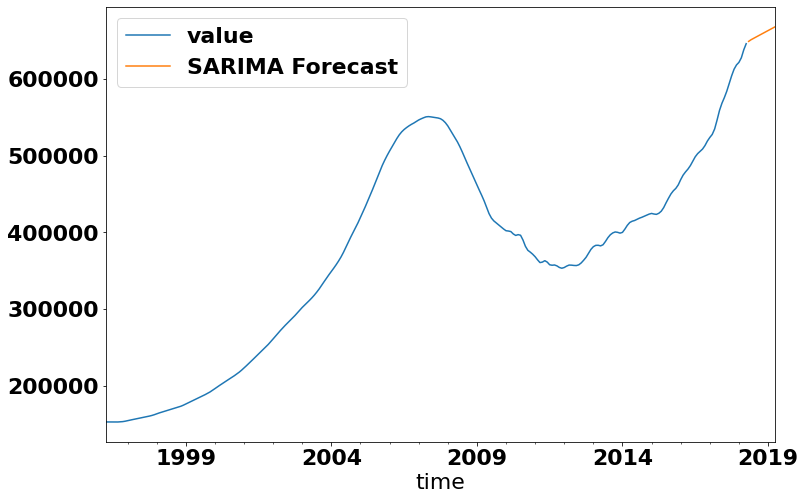

In [136]:
hudson_monthly['value'].plot(legend=True, figsize=(12,8))
fcast.plot(legend=True);

In [137]:
def get_top_counties(df, n_top_counties=3):
    
    #get unique counties from dataframe as list
    unique_counties = []
    for c in nj_df.CountyName.unique():
        unique_counties.append(c)
    print(unique_counties)
    
    #set up empty dictionary to store model, aic, county 
    county_dict = {County: unique_counties, {model:'', aic:''}}
    
    #iterate over counties (for county in counties list)
    for county in unique_counties:
    
    #slice out county from dataframe, only see rows where county = county
    nj_df[(nj_df['CountyName'] == county)]
    
    #split data
    train = df.iloc[:229]
    test = df.iloc[229:]
    
    #iterate over model orders to try to find the best model
    for model in county_dict:
        return county_dict[County][aic]

SyntaxError: invalid syntax (<ipython-input-137-d34138ad9ac1>, line 10)

In [ ]:
unique_counties = []
for c in nj_df.CountyName.unique():
    unique_counties.append(c)
print(unique_counties)

In [ ]:
highest_number = 0
numbers_lst = [0,1,2,5,1,10,9,8,7,10,5]
for num in numbers_lst:
    if num > highest_number:
        highest_number = num
print(highest_number)